In [65]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import lightgbm as lgb

from catboost import CatBoostClassifier, CatBoostRegressor

from tqdm import tqdm

from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, matthews_corrcoef, precision_score, recall_score, make_scorer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Data Preparation + Insights

In [2]:
RANDOM_STATE = 42 
LABEL_COLS = ["CPPG.STATUS_SPS", "CPPG.STATUS_U0", "CPPG.STATUS_HEIGHT", "CPPG.STATUS_IMPEDANCE", "CPPG.STATUS_FORMATION", "CPPG.STATUS_MODUL"]

In [4]:
df = pd.read_excel("Data/TMTSA_Daten.xlsx")

Remove all Columns with only 1 value (no information gain for the algorithm) --> Removing 24 Columns

In [54]:
columns_without_information_gain = []

for column in df.columns:
    if len(df[column].value_counts()) == 1:
        columns_without_information_gain.append(column)

df_only_information_gain = df.drop(columns_without_information_gain, axis=1)

In [55]:
columns_without_information_gain

['CPW.Werk',
 'CPW.CATHODE_FZLENGTH_LOWER',
 'CPM.Werk',
 'CPX.Werk',
 'CPFORM.SenderName',
 'CPFORM.PROCESSDESCRIPTION',
 'CPFORM.Werk',
 'CPPG.Werk',
 'CPPG.STATUS_MODUL',
 'CPX.Werk_1',
 'CPX.Werk_2',
 'CPW.QUALITY_INSPECTION',
 'CPX.CONV_Result001_1',
 'CPM.RejectScan',
 'CPM.RejectScan1',
 'CPX.CONV_Result001_2',
 'CPX.CONV_ACOHs047_2',
 'CPX.CONV_ACOHs048_2',
 'CPM.RejectWelding',
 'CPPG.REJECTED',
 'CPW.Soll_DMC',
 'CPX.CONV_ACOHs049',
 'CPX.CONV_ACOHs050',
 'CPM.WeldLogfile_Nr']

In [56]:
df_only_information_gain.head()

,Unnamed: 0,ID,CPW.Name,CPW.Linie,CPW.Timestamp,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,...,CPX.CONV_ACOHs043_2,CPX.CONV_ACOHs044_2,CPX.CONV_ACOHs045_2,CPX.CONV_ACOHs046_2,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1
0,0,1,CPMW26,710.0,2022-08-29 02:00:32,61.268271,350.282969,9.179729,302.502813,12.28662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,CPMW23,707.0,2022-08-20 12:42:20,57.259561,348.452969,10.880899,301.902344,12.26344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3,CPMW53,725.0,2022-08-31 16:23:37,58.295284,351.588750,10.690954,302.626719,12.29760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,4,CPMW27,711.0,2022-10-11 17:54:46,62.750492,351.843710,10.240900,303.179531,12.22806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5,CPMW23,707.0,2022-08-24 22:20:35,57.823748,350.698770,10.889323,310.547188,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Manually removing unnecessary and forbidden columns

In [57]:
unnecessary_columns = [
        "Unnamed: 0", 
        "ID", 
        "CPW.Linie", 
        "CPM.Linie", 
        "CPM.CellcodeGrade", 
        "CPM.Weld_Logfile_Nr", 
        "CPX.Linie", 
        "CPFORM.Filename", 
        "CPFORM.TestNumber", 
        "CPFORM.Reasoncode", 
        "CPFORM.Reasoncodename", 
        "CPX.TrayResult"
    ]

not_allowed_columns = [
        "CPPG.SenderName", 
        "CPPG.SenderTimestamp", 
        "CPPG.Impedance_mOhm", 
        "CPPG.Height_mm", 
        "CPPG.U0_mV", 
        "CPPG.Cell Status",
        "CPPG.STATUS_SPS",
        "CPPG.STATUS_U0",
        "CPPG.STATUS_HEIGHT",
        "CPPG.STATUS_IMPEDANCE",
        "CPPG.STATUS_FORMATION"
    ]

df_removed_cols = df_only_information_gain.drop(unnecessary_columns + not_allowed_columns, axis=1)

In [58]:
df_removed_cols.head()

,CPW.Name,CPW.Timestamp,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,CPW.DIAMTER_MIN,CPW.DIAMTER_AVERAGE,CPW.ANODETABPOSITION,...,CPX.CONV_ACOHs043_2,CPX.CONV_ACOHs044_2,CPX.CONV_ACOHs045_2,CPX.CONV_ACOHs046_2,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1
0,CPMW26,2022-08-29 02:00:32,61.268271,350.282969,9.179729,302.502813,12.28662,12.03286,12.12436,91.861033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CPMW23,2022-08-20 12:42:20,57.259561,348.452969,10.880899,301.902344,12.26344,12.13656,12.20000,49.241435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CPMW53,2022-08-31 16:23:37,58.295284,351.588750,10.690954,302.626719,12.29760,12.04140,12.14632,120.583939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CPMW27,2022-10-11 17:54:46,62.750492,351.843710,10.240900,303.179531,12.22806,12.04628,12.11948,368.920286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CPMW23,2022-08-24 22:20:35,57.823748,350.698770,10.889323,310.547188,0.00000,0.00000,0.00000,196.501964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Cluster the retests and save the information as bool/num variable

In [59]:
x_ray_0_cols = [f"CPX.AI_ACOHs00{i}" if i < 10 else f"CPX.AI_ACOHs0{i}" for i in range(1, 53)] + [
    "CPX.AI_Result001", 
    "CPX.Tab_Overhang001", 
    "CPX.DIFF_Y1001", 
    "CPX.DIFF_Y2001",
    "CPX.Failure_Code001",
    "CPX.Name",
    "CPX.Xray_Timestamp",
    "CPX.Result"
]

x_ray_1_cols = [f"CPX.AI_ACOHs00{i}_1" if i < 10 else f"CPX.AI_ACOHs0{i}_1" for i in range(1, 53)] + [
    "CPX.AI_Result001_1", 
    "CPX.Tab_Overhang001_1", 
    "CPX.DIFF_Y1001_1", 
    "CPX.DIFF_Y2001_1",
    "CPX.Failure_Code001_1",
    "CPX.Name_1",
    "CPX.Xray_Timestamp_1",
    "CPX.Result_1"
]

x_ray_2_cols = [f"CPX.AI_ACOHs00{i}_2" if i < 10 else f"CPX.AI_ACOHs0{i}_2" for i in range(1, 53)] + [
    "CPX.AI_Result001_2", 
    "CPX.Tab_Overhang001_2", 
    "CPX.DIFF_Y1001_2", 
    "CPX.DIFF_Y2001_2",
    "CPX.Failure_Code001_2",
    "CPX.Name_2",
    "CPX.Xray_Timestamp_2",
    "CPX.Result_2"
]

In [60]:
df_x_ray_cluster = df_removed_cols.copy()
retest_bool = []
retest_num = []

for index, row in df_removed_cols.iterrows():
    for position, column in enumerate(x_ray_0_cols):
        boolean = None
        number = None
        if not pd.isna(row[x_ray_2_cols[position]]):
            df_x_ray_cluster.loc[index, column] = row[x_ray_2_cols[position]]  
            boolean = True
            number = 2
        elif not pd.isna(row[x_ray_1_cols[position]]):
            df_x_ray_cluster.loc[index, column] = row[x_ray_1_cols[position]]
            boolean = True
            number = 1
        else:
            boolean = False
            number = 0
    retest_bool.append(boolean)
    retest_num.append(number)

df_x_ray_cluster["CPX.Retest_Bool"] = retest_bool
df_x_ray_cluster["CPX.Retest_Num"] = retest_num

In [63]:
# Removing 120 columns (still some x ray cols included which will be removed based on feature importance)
df_x_ray_cleaned = df_x_ray_cluster.drop(x_ray_1_cols + x_ray_2_cols, axis=1)

In [64]:
df_x_ray_cleaned["CPX.Retest_Num"].value_counts()

CPX.Retest_Num
0    981788
1     18099
2       113
Name: count, dtype: int64

In [65]:
df_x_ray_cleaned.head()

,CPW.Name,CPW.Timestamp,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,CPW.DIAMTER_MIN,CPW.DIAMTER_AVERAGE,CPW.ANODETABPOSITION,...,CPX.CONV_ACOHs045_2,CPX.CONV_ACOHs046_2,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1,CPX.Retest_Bool,CPX.Retest_Num
0,CPMW26,2022-08-29 02:00:32,61.268271,350.282969,9.179729,302.502813,12.28662,12.03286,12.12436,91.861033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
1,CPMW23,2022-08-20 12:42:20,57.259561,348.452969,10.880899,301.902344,12.26344,12.13656,12.20000,49.241435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
2,CPMW53,2022-08-31 16:23:37,58.295284,351.588750,10.690954,302.626719,12.29760,12.04140,12.14632,120.583939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
3,CPMW27,2022-10-11 17:54:46,62.750492,351.843710,10.240900,303.179531,12.22806,12.04628,12.11948,368.920286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
4,CPMW23,2022-08-24 22:20:35,57.823748,350.698770,10.889323,310.547188,0.00000,0.00000,0.00000,196.501964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0


Duration aus Timestamps berechnen und originale Timestamps entfernen

In [66]:
# df_x_ray_cluster["CPW.Duration"] = 
cpw_duration = df_x_ray_cleaned["CPM.Timestamp"]-df_x_ray_cleaned["CPW.Timestamp"]
cpw_duration = cpw_duration.dt.total_seconds()

cpm_duration = df_x_ray_cleaned["CPX.Xray_Timestamp"]-df_x_ray_cleaned["CPM.Timestamp"]
cpm_duration = cpm_duration.dt.total_seconds()

df_x_ray_cleaned["CPW.Duration"] = cpw_duration
df_x_ray_cleaned["CPM.Duration"] = cpm_duration

df_prepared = df_x_ray_cleaned.drop(["CPW.Timestamp", "CPM.Timestamp", "CPX.Xray_Timestamp"], axis=1) # Remove unnecessary timestamps (other timestamps will be removed later as CPForm data will be removed)

In [67]:
df_prepared.head()

,CPW.Name,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,CPW.DIAMTER_MIN,CPW.DIAMTER_AVERAGE,CPW.ANODETABPOSITION,CPW.CATHODETABPOSITION,...,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1,CPX.Retest_Bool,CPX.Retest_Num,CPW.Duration,CPM.Duration
0,CPMW26,61.268271,350.282969,9.179729,302.502813,12.28662,12.03286,12.12436,91.861033,1.173663,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,395044.0,33503.0
1,CPMW23,57.259561,348.452969,10.880899,301.902344,12.26344,12.13656,12.20000,49.241435,402.458856,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,734387.0,2131.0
2,CPMW53,58.295284,351.588750,10.690954,302.626719,12.29760,12.04140,12.14632,120.583939,53.235782,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,335387.0,19343.0
3,CPMW27,62.750492,351.843710,10.240900,303.179531,12.22806,12.04628,12.11948,368.920286,268.658312,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,126924.0,32637.0
4,CPMW23,57.823748,350.698770,10.889323,310.547188,0.00000,0.00000,0.00000,196.501964,106.837010,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,476852.0,32222.0


Removing the cp_form step values (12 Columns)

In [68]:
cp_form_features = ["CPFORM.SenderTimestamp", "CPFORM.StartTime", "CPFORM.Duration_s", "CPFORM.TrayXID", "CPFORM.TrayPosition", "CPFORM.QualityStatus", "CPFORM.Grade", "CPFORM.ChgCap_mAh_Cycle0/0", "CPFORM.DsgCap_mAh_Cycle0/0", "CPFORM.OCV1_mV", "CPFORM.OCV1_Timestamp", "CPFORM.Rack"]

df_no_cp_form = df_prepared.drop(cp_form_features, axis=1)

In [69]:
df_no_cp_form.head()

,CPW.Name,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,CPW.DIAMTER_MIN,CPW.DIAMTER_AVERAGE,CPW.ANODETABPOSITION,CPW.CATHODETABPOSITION,...,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1,CPX.Retest_Bool,CPX.Retest_Num,CPW.Duration,CPM.Duration
0,CPMW26,61.268271,350.282969,9.179729,302.502813,12.28662,12.03286,12.12436,91.861033,1.173663,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,395044.0,33503.0
1,CPMW23,57.259561,348.452969,10.880899,301.902344,12.26344,12.13656,12.20000,49.241435,402.458856,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,734387.0,2131.0
2,CPMW53,58.295284,351.588750,10.690954,302.626719,12.29760,12.04140,12.14632,120.583939,53.235782,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,335387.0,19343.0
3,CPMW27,62.750492,351.843710,10.240900,303.179531,12.22806,12.04628,12.11948,368.920286,268.658312,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,126924.0,32637.0
4,CPMW23,57.823748,350.698770,10.889323,310.547188,0.00000,0.00000,0.00000,196.501964,106.837010,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,476852.0,32222.0


In [70]:
# Calculate the min an max value for each column, which includes error values
# The idea is that each error value will be 0 after replacement + normalization so the "error" needs to be replaced 
# --> so this value will be replaced with the min value of the column - d * range of the column

replacement_dict = {}

for i in range(1, 49):
    for j in range(3):
        col_name = None
        if (i == 47 or i == 48) and j == 2:
            continue
        if i < 10:
            if j == 0:
                col_name = f"CPX.CONV_ACOHs00{i}"
            else:
                col_name = f"CPX.CONV_ACOHs00{i}_{j}"
        else:
            if j == 0:
                col_name = f"CPX.CONV_ACOHs0{i}"
            else:
                col_name = f"CPX.CONV_ACOHs0{i}_{j}"
        column = df_no_cp_form[col_name]
        column_no_error = column[~column.isin(["error"])].mean()
        column = column.replace("error", column_no_error.mean())
        replacement_dict[col_name] = [column.min(), column.max()]

Manually encode columns with mixed datatypes (f.e. floating values in object column --> no label encoding in raw form possible)

In [71]:
df_replaced = df_no_cp_form.copy()
d = 0.1

for i in range(1, 49):
    for j in range(3):
        col_name = None
        if (i == 47 or i == 48) and j == 2:
            continue
        if i < 10:
            if j == 0:
                col_name = f"CPX.CONV_ACOHs00{i}"
            else:
                col_name = f"CPX.CONV_ACOHs00{i}_{j}"
        else:
            if j == 0:
                col_name = f"CPX.CONV_ACOHs0{i}"
            else:
                col_name = f"CPX.CONV_ACOHs0{i}_{j}"
        max_val = replacement_dict[col_name][1]
        min_val = replacement_dict[col_name][0]
        replacement_value = min_val - d * (max_val - min_val)
        df_replaced[col_name] = df_no_cp_form[col_name].replace("error", replacement_value)

Encode remaining values to categorical --> save classes in dict for possible decoding

In [72]:
df_encoded = df_replaced.copy()
encoding_dict = {}

for index, val in enumerate(df_replaced.dtypes):
    if val == "object" or val == "datetime64[ns]":
        col_name = df_replaced.columns[index]
        print(col_name)
        le = LabelEncoder()
        df_encoded[col_name] = le.fit_transform(df_replaced[col_name])
        encoding_dict[col_name] = le.classes_

CPW.Name
CPM.MaxTimeWT
CPM.Name
CPX.AI_Result001
CPX.Name
CPX.Result
CPX.Linie_1
CPX.TrayResult_1
CPX.CONV_Result001
CPX.Linie_2
CPX.TrayResult_2


In [73]:
df_encoded.head()

,CPW.Name,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,CPW.DIAMTER_MIN,CPW.DIAMTER_AVERAGE,CPW.ANODETABPOSITION,CPW.CATHODETABPOSITION,...,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1,CPX.Retest_Bool,CPX.Retest_Num,CPW.Duration,CPM.Duration
0,5,61.268271,350.282969,9.179729,302.502813,12.28662,12.03286,12.12436,91.861033,1.173663,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,395044.0,33503.0
1,2,57.259561,348.452969,10.880899,301.902344,12.26344,12.13656,12.20000,49.241435,402.458856,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,734387.0,2131.0
2,16,58.295284,351.588750,10.690954,302.626719,12.29760,12.04140,12.14632,120.583939,53.235782,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,335387.0,19343.0
3,6,62.750492,351.843710,10.240900,303.179531,12.22806,12.04628,12.11948,368.920286,268.658312,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,126924.0,32637.0
4,2,57.823748,350.698770,10.889323,310.547188,0.00000,0.00000,0.00000,196.501964,106.837010,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,476852.0,32222.0


Min Max Normalization for each column --> save min and max value for each column befor normalization for possible decoding

In [74]:
normalization_dict = {}

for index, name in enumerate(df_encoded.columns):
    normalization_dict[name] = [df_encoded[name].min(), df_encoded[name].max()]

scaler = MinMaxScaler()
df_scaled = df_encoded.apply(lambda column: pd.Series(scaler.fit_transform(column.values.reshape(-1, 1)).flatten()))


In [75]:
df_scaled.head()

,CPW.Name,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,CPW.DIAMTER_MIN,CPW.DIAMTER_AVERAGE,CPW.ANODETABPOSITION,CPW.CATHODETABPOSITION,...,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1,CPX.Retest_Bool,CPX.Retest_Num,CPW.Duration,CPM.Duration
0,0.192308,0.301151,0.003236,0.686540,0.006666,0.977767,0.981295,0.984448,0.209158,0.002674,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.118489,0.007054
1,0.076923,0.285979,0.003219,0.813174,0.006653,0.975922,0.989752,0.990589,0.112118,0.916349,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.220644,0.004977
2,0.615385,0.289899,0.003248,0.799034,0.006668,0.978641,0.981992,0.986231,0.274556,0.121213,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.100530,0.006116
3,0.230769,0.306761,0.003250,0.765533,0.006681,0.973107,0.982390,0.984051,0.839987,0.611703,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.037775,0.006997
4,0.076923,0.288114,0.003240,0.813801,0.006843,0.000000,0.000000,0.000000,0.447412,0.243256,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.143117,0.006969


Remove N/A values --> Categorical data with modus / Numerical Data with mean (Categorical values are all stored in the encoding dict; manual encoding was all on numerical values)

--> After checking the values, there is no missing value for the categorical data, so only the missing numerical values will be calculated (can be checked with code below but takes 30min)

In [132]:
# for col_idx, column in enumerate(df_scaled.columns):
#     for row_idx, cell in enumerate(df_scaled[column]):
#         if pd.isna(df_scaled.loc[row_idx, column]):
#             if column in encoding_dict.keys():
#                 print(column)

In [76]:
final_df = df_scaled.copy()

for column in final_df.columns:
    mean_value = final_df[column].mean()
    final_df[column] = final_df[column].fillna(mean_value)

In [77]:
# Check that no N/A is remaining
for val in final_df.isna().sum():
    if val != 0:
        print(val)

In [78]:
final_df.head()

,CPW.Name,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,CPW.DIAMTER_MIN,CPW.DIAMTER_AVERAGE,CPW.ANODETABPOSITION,CPW.CATHODETABPOSITION,...,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1,CPX.Retest_Bool,CPX.Retest_Num,CPW.Duration,CPM.Duration
0,0.192308,0.301151,0.003236,0.686540,0.006666,0.977767,0.981295,0.984448,0.209158,0.002674,...,0.346099,0.323453,0.407145,0.53664,0.5,0.0,0.0,0.0,0.118489,0.007054
1,0.076923,0.285979,0.003219,0.813174,0.006653,0.975922,0.989752,0.990589,0.112118,0.916349,...,0.346099,0.323453,0.407145,0.53664,0.5,0.0,0.0,0.0,0.220644,0.004977
2,0.615385,0.289899,0.003248,0.799034,0.006668,0.978641,0.981992,0.986231,0.274556,0.121213,...,0.346099,0.323453,0.407145,0.53664,0.5,0.0,0.0,0.0,0.100530,0.006116
3,0.230769,0.306761,0.003250,0.765533,0.006681,0.973107,0.982390,0.984051,0.839987,0.611703,...,0.346099,0.323453,0.407145,0.53664,0.5,0.0,0.0,0.0,0.037775,0.006997
4,0.076923,0.288114,0.003240,0.813801,0.006843,0.000000,0.000000,0.000000,0.447412,0.243256,...,0.346099,0.323453,0.407145,0.53664,0.5,0.0,0.0,0.0,0.143117,0.006969


In [79]:
# with open("final_df.pickle", "wb") as f:
#     pickle.dump(final_df, f)

# with open("initial_df.pickle", "wb") as f:
#     pickle.dump(df, f)

# -------------------------------------- LABELS ----------------------------------------

In [80]:
cppg_df = df[LABEL_COLS]
cppg_df.head()

,CPPG.STATUS_SPS,CPPG.STATUS_U0,CPPG.STATUS_HEIGHT,CPPG.STATUS_IMPEDANCE,CPPG.STATUS_FORMATION,CPPG.STATUS_MODUL
0,PASS,PASS,PASS,PASS,PASS,NaN
1,PASS,PASS,PASS,PASS,NaN,PASS
2,PASS,PASS,PASS,PASS,NaN,PASS
3,PASS,PASS,PASS,PASS,PASS,NaN
4,PASS,PASS,PASS,PASS,PASS,NaN


In [81]:
for column in cppg_df.columns:
    print(cppg_df[column].value_counts())

CPPG.STATUS_SPS
PASS              973404
IMPEDANCE_FAIL     12876
VOLTAGE_FAIL        8392
U0_FAIL             2560
FORMATION_FAIL      1507
HEIGHT_FAIL         1201
NO CELL               51
_FAIL                  9
Name: count, dtype: int64
CPPG.STATUS_U0
PASS       987590
FAIL        12359
NO CELL        51
Name: count, dtype: int64
CPPG.STATUS_HEIGHT
PASS       998619
FAIL         1330
NO CELL        51
Name: count, dtype: int64
CPPG.STATUS_IMPEDANCE
PASS       985586
FAIL        14363
NO CELL        51
Name: count, dtype: int64
CPPG.STATUS_FORMATION
PASS       400555
FAIL         1507
NO CELL        51
Name: count, dtype: int64
CPPG.STATUS_MODUL
PASS    597887
Name: count, dtype: int64


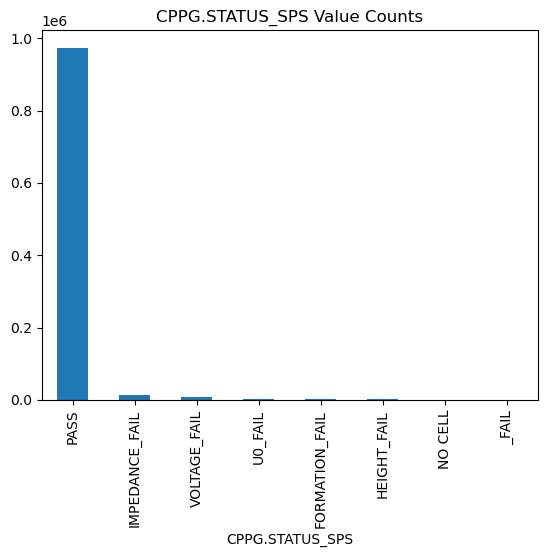

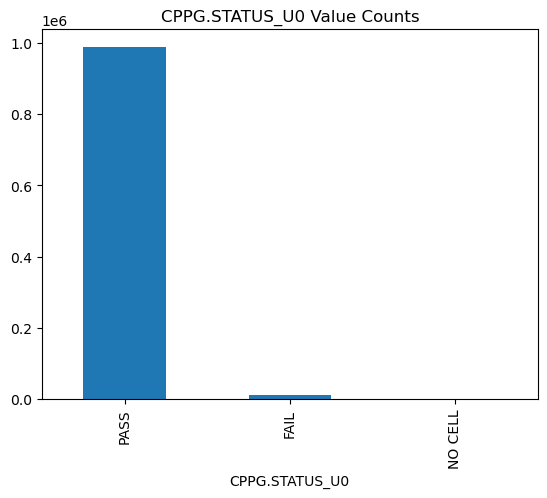

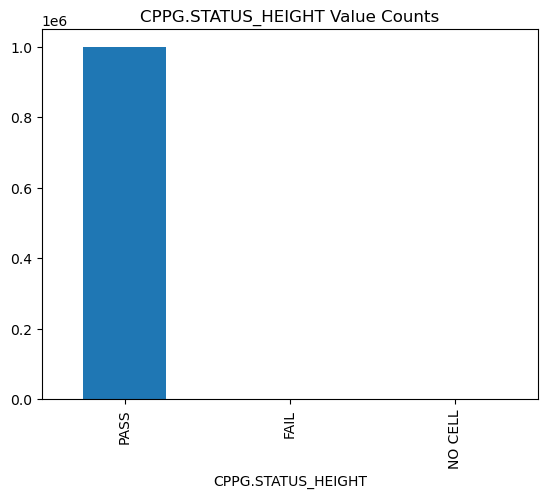

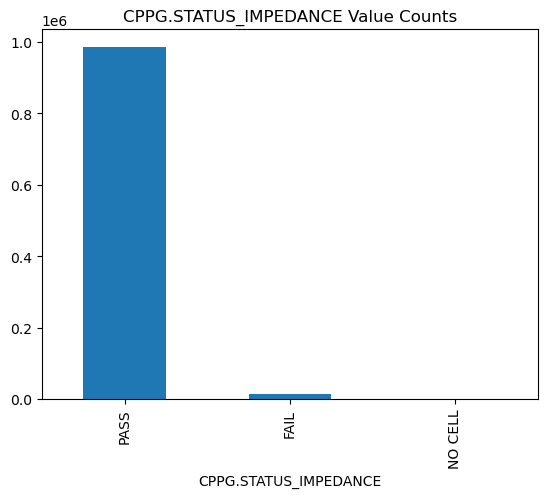

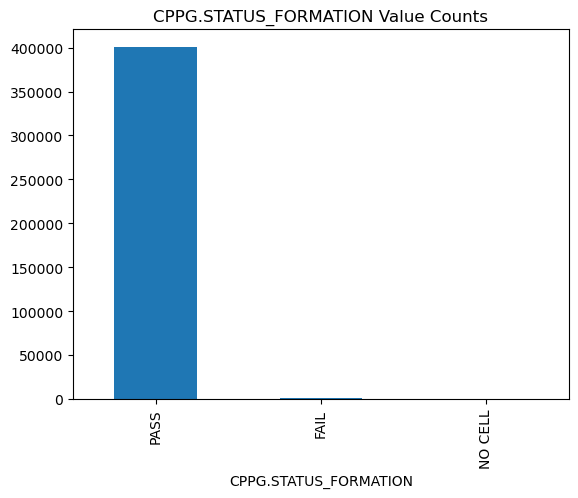

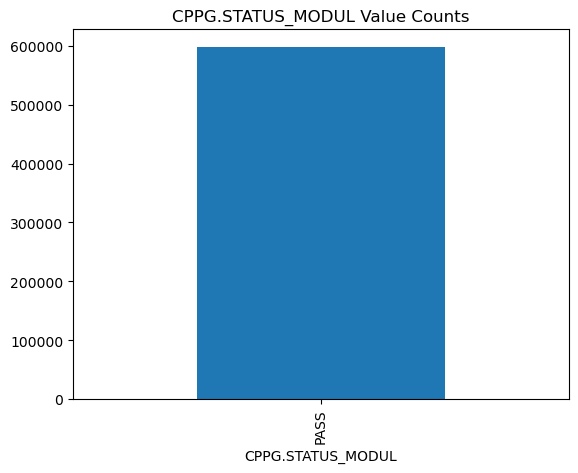

In [82]:
for column in cppg_df.columns:
    plt.figure()
    cppg_df[column].value_counts().plot.bar()
    plt.title(f'{column} Value Counts')
plt.show()

TODO: zuerst prüfen ob Classification Binary möglich, dann multi-class (different Failures)

In [83]:
# Check here, whether other Fail Values are in DF
y = []

contains_failure = cppg_df.isin(["FAIL"]).any(axis=1)

for item in contains_failure:
    if item:
        y.append("FAIL")
    else:
        y.append("PASS")

In [33]:
# with open("labels_clustered.pickle", "wb") as f:
#     pickle.dump(y, f)

# with open("labels.pickle", "wb") as f:
#     pickle.dump(cppg_df, f)

In [3]:
with open("final_df.pickle", "rb") as f:
    final_df = pickle.load(f)

with open("labels.pickle", "rb") as f:
    y = pickle.load(f)

with open("labels_clustered.pickle", "rb") as f:
    y_clustered = pickle.load(f)

In [4]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_clustered)

value_distribution = pd.DataFrame([le.classes_[line] for line in y_encoded])
print(value_distribution.value_counts())

PASS    973464
FAIL     26536
Name: count, dtype: int64


In [5]:
# y_one_hot = to_categorical(y_encoded)

Undersampling values for testing

In [41]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=RANDOM_STATE)

x_resampled, y_resampled = rus.fit_resample(final_df, y_encoded)

In [7]:
# y_resampled = to_categorical(y_resampled)

# Different Models Comparison

## Spot Checking

In [33]:
def all_models():
    return [
        ('Decision Tree', DecisionTreeClassifier(random_state=RANDOM_STATE)),
        ('Random Forest', RandomForestClassifier(random_state=RANDOM_STATE)),
        ('Extremely Randomized Trees', ExtraTreesClassifier(random_state=RANDOM_STATE)),
        ('Ada Boost', AdaBoostClassifier(random_state=RANDOM_STATE)),
        ('Gradient Boosting', GradientBoostingClassifier(random_state=RANDOM_STATE)),
        ('Support Vector Machine', SVC(random_state=RANDOM_STATE)),
        ('Multilayer Perceptron', MLPClassifier(random_state=RANDOM_STATE)),
        ('Naive Bayes', GaussianNB()),
        # ('KNN', KNeighborsClassifier())
    ]

scorings = {
    'accuracy': make_scorer(accuracy_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'f1_score': make_scorer(f1_score),
    'mcc': make_scorer(matthews_corrcoef),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
}

In [89]:
all_cv_scores = []

for classifier_name, classifier in tqdm(all_models()):
    formatted_result = {}
    formatted_result['Classifier'] = classifier_name

    cv_score = cross_validate(estimator=classifier, X=x_resampled, y=y_resampled, scoring=scorings)

    for score_name, scores in cv_score.items():
        formatted_result[f'{score_name}_mean'] = np.mean(scores)
        formatted_result[f'{score_name}_std'] = np.std(scores)

    all_cv_scores.append(formatted_result)

 75%|███████▌  | 6/8 [44:10<24:12, 726.27s/it]c:\Users\Dominik Hahn\anaconda3\envs\check_gpu_neu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Dominik Hahn\anaconda3\envs\check_gpu_neu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|██████████| 8/8 [47:52<00:00, 359.12s/it]


In [90]:
pd.DataFrame(all_cv_scores)

,Classifier,fit_time_mean,fit_time_std,score_time_mean,score_time_std,test_accuracy_mean,test_accuracy_std,test_balanced_accuracy_mean,test_balanced_accuracy_std,test_f1_score_mean,test_f1_score_std,test_mcc_mean,test_mcc_std,test_precision_mean,test_precision_std,test_recall_mean,test_recall_std
0,Decision Tree,8.326296,0.164635,0.026807,0.000980,0.643371,0.002257,0.643372,0.002257,0.642428,0.001805,0.286777,0.004537,0.644180,0.004076,0.640752,0.005731
1,Random Forest,37.364999,0.088898,0.201645,0.000800,0.731478,0.004971,0.731478,0.004971,0.727898,0.004593,0.463144,0.009978,0.737793,0.006616,0.718307,0.005435
2,Extremely Randomized Trees,13.962944,0.094414,0.276862,0.006243,0.727936,0.005188,0.727936,0.005188,0.727555,0.004881,0.455882,0.010377,0.728605,0.005983,0.726523,0.004680
3,Ada Boost,28.227951,0.252147,0.387487,0.009954,0.715537,0.004136,0.715537,0.004136,0.713480,0.004214,0.431120,0.008271,0.718677,0.004190,0.708358,0.004332
4,Gradient Boosting,144.577302,1.635258,0.042810,0.004119,0.723809,0.003254,0.723809,0.003255,0.716517,0.003677,0.448223,0.006486,0.735947,0.003632,0.698108,0.005284
5,Support Vector Machine,245.712112,0.995928,50.914860,0.071796,0.693643,0.004563,0.693643,0.004562,0.679901,0.005506,0.388759,0.009139,0.711849,0.005853,0.650777,0.008879
6,Multilayer Perceptron,44.139722,11.553525,0.037208,0.003488,0.698071,0.006902,0.698071,0.006902,0.711023,0.006081,0.398341,0.012110,0.682315,0.013476,0.743218,0.023813
7,Naive Bayes,0.267060,0.014659,0.063414,0.003323,0.521801,0.000985,0.521801,0.001001,0.675157,0.000559,0.132380,0.005102,0.511214,0.000506,0.993895,0.001029


Best Accuracy Mean: Random Forest 73,15%

## Spot Checking with previously removed imbalances

In [61]:
all_cv_scores_without_imbalance = []

oversampler = RandomOverSampler(random_state=RANDOM_STATE)
x_over, y_over = oversampler.fit_resample(X=df_no_na, y=le.fit_transform(y))

for classifier_name, classifier in tqdm(all_models()):
    formatted_result_over = {}
    formatted_result_over['Classifier'] = classifier_name

    cv_score = cross_validate(estimator=classifier, X=x_over, y=y_over, scoring=scorings)

    for score_name, scores in cv_score.items():
        formatted_result_over[f'{score_name}_mean'] = np.mean(scores)
        formatted_result_over[f'{score_name}_std'] = np.std(scores)

    all_cv_scores_without_imbalance.append(formatted_result_over)

100%|██████████| 9/9 [00:03<00:00,  2.51it/s]


In [62]:
pd.DataFrame(all_cv_scores_without_imbalance)

,Classifier,fit_time_mean,fit_time_std,score_time_mean,score_time_std,test_accuracy_mean,test_accuracy_std,test_balanced_accuracy_mean,test_balanced_accuracy_std,test_f1_score_mean,test_f1_score_std,test_mcc_mean,test_mcc_std,test_precision_mean,test_precision_std,test_recall_mean,test_recall_std
0,Decision Tree,0.003702,0.000748,0.003200,0.000401,0.995888,0.003085,0.995892,0.003074,0.995866,0.003114,0.991829,0.006093,1.000000,0.000000,0.991784,0.006149
1,Random Forest,0.112172,0.001289,0.009962,0.000083,0.998972,0.001259,0.998974,0.001256,0.998972,0.001259,0.997949,0.002512,1.000000,0.000000,0.997949,0.002512
2,Extremely Randomized Trees,0.080817,0.002773,0.011203,0.000980,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
3,Ada Boost,0.079149,0.000696,0.007608,0.000487,0.995375,0.002997,0.995374,0.002997,0.995343,0.003021,0.990811,0.005947,1.000000,0.000000,0.990748,0.005993
4,Gradient Boosting,0.223380,0.001430,0.002939,0.000123,0.995374,0.003779,0.995371,0.003783,0.995335,0.003823,0.990818,0.007480,1.000000,0.000000,0.990743,0.007566
5,Support Vector Machine,0.052081,0.001980,0.037913,0.002800,0.560641,0.007405,0.560653,0.006770,0.691683,0.004281,0.230188,0.019414,0.532810,0.004697,0.985615,0.005041
6,Multilayer Perceptron,0.062324,0.004194,0.003198,0.000402,0.608409,0.044981,0.608388,0.044990,0.583019,0.182454,0.279745,0.118470,0.607535,0.024857,0.680185,0.348492
7,Naive Bayes,0.001600,0.000490,0.002800,0.000400,0.504112,0.003848,0.504116,0.003097,0.016255,0.012075,0.061013,0.020590,1.000000,0.000000,0.008232,0.006194
8,KNN,0.001800,0.000400,0.014380,0.000512,0.944498,0.020993,0.944526,0.020995,0.943279,0.019389,0.892480,0.042413,0.975845,0.048309,0.914692,0.018328


Everything except Naive Bayes/KNN Performing quite Well

Best: Extremely Randomized Trees: Balanced Acc: 100%

## Feature Selection

Here for the Dataset all features will be taken into consideration

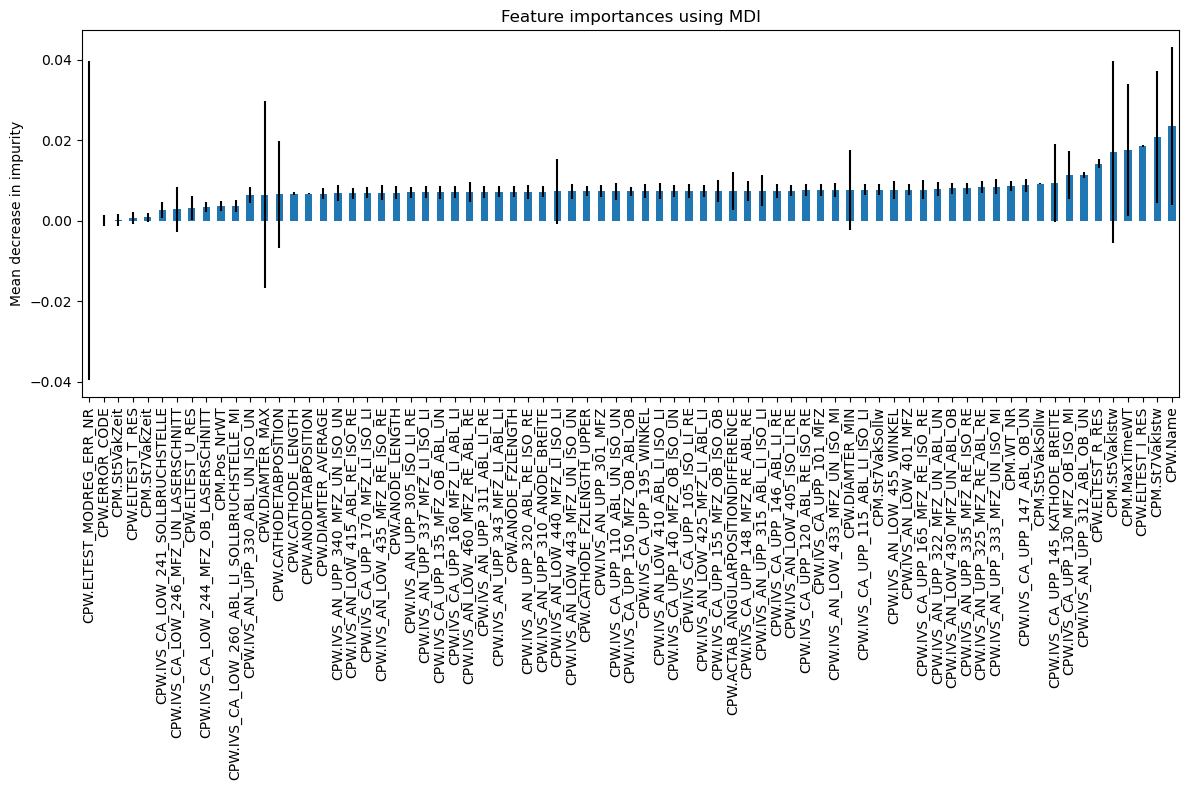

In [50]:
number_of_features = 75

x_train_feat, x_test_feat, y_train_feat, y_test_feat = train_test_split(x_resampled, y_resampled, random_state=RANDOM_STATE)

# oversampler = RandomOverSampler(random_state=RANDOM_STATE)
# x_train_feat_over, y_train_feat_over = oversampler.fit_resample(x_train_feat, y_train_feat)

random_forest = RandomForestClassifier(random_state=RANDOM_STATE)
random_forest.fit(x_train_feat, y_train_feat)
feature_importances = random_forest.feature_importances_[:number_of_features]
standard_deviation_importances = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)[:number_of_features]

forest_importances = pd.Series(feature_importances, index=x_resampled.columns[:number_of_features])
forest_importances = forest_importances.sort_values()

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
forest_importances.plot.bar(yerr=standard_deviation_importances, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [51]:
selector = SelectFromModel(estimator=random_forest, prefit=True)
x_data_selected = selector.transform(x_resampled)
best_features = selector.get_feature_names_out(x_resampled.columns)
x_data_selected = pd.DataFrame(x_data_selected[:,:number_of_features], columns=best_features[:number_of_features])
x_data_selected.head()

c:\Users\Dominik Hahn\anaconda3\envs\check_gpu_neu\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


,CPW.Name,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,CPW.DIAMTER_MIN,CPW.DIAMTER_AVERAGE,CPW.ANODETABPOSITION,CPW.CATHODETABPOSITION,...,CPM.St5VakIstw,CPM.St5VakSollw,CPM.St3VakIstw,CPM.St3VakSollw,CPM.WeldCount,CPM.WeldResistance_microOhm,CPM.Name,CPX.AI_ACOHs001,CPX.AI_ACOHs002,CPX.AI_ACOHs003
0,0.192308,0.288943,0.003238,0.763647,0.006635,0.974757,0.982987,0.984151,0.110626,0.952026,...,0.231466,0.898333,0.122544,0.898333,0.052935,0.000000,0.866667,0.900881,0.817471,0.531747
1,0.807692,0.286520,0.003200,0.793200,0.006651,0.979029,0.982788,0.984250,0.719249,0.555135,...,0.249320,0.900000,0.149431,0.900000,0.235452,0.492316,0.666667,0.878451,0.815640,0.541570
2,0.076923,0.287636,0.003203,0.781832,0.006657,0.976893,0.981196,0.984844,0.274082,0.046617,...,0.231829,0.898333,0.125336,0.898333,0.007438,0.512466,0.800000,0.891279,0.813061,0.557568
3,0.230769,0.287253,0.003256,0.916610,0.006683,0.978738,0.984579,0.987023,0.992854,0.810332,...,0.231648,0.898333,0.125336,0.898333,0.063165,0.516393,0.800000,0.907719,0.826853,0.537943
4,0.038462,0.291270,0.003234,0.709362,0.006690,0.984369,0.982589,0.986330,0.756578,0.632159,...,0.238354,0.898333,0.117890,0.898333,0.089072,0.546960,0.800000,0.900945,0.823193,0.593688


In [52]:
all_cv_scores_selected = []

# oversampler = RandomOverSampler(random_state=RANDOM_STATE)
# Important to use the selected features in here to see if the feature selection has a benefit onto the different classifiers
# x_over_selected, y_over_selected = oversampler.fit_resample(X=x_data_selected, y=le.fit_transform(y))

for classifier_name, classifier in tqdm(all_models()):
    print(f"[INFO] ---- Validation for {classifier_name}")
    formatted_result_selected = {}
    formatted_result_selected['Classifier'] = classifier_name

    cv_score = cross_validate(estimator=classifier, X=x_data_selected, y=y_resampled, scoring=scorings)

    for score_name, scores in cv_score.items():
        formatted_result_selected[f'{score_name}_mean'] = np.mean(scores)
        formatted_result_selected[f'{score_name}_std'] = np.std(scores)

    all_cv_scores_selected.append(formatted_result_selected)

  0%|          | 0/8 [00:00<?, ?it/s]

[INFO] ---- Validation for Decision Tree


 12%|█▎        | 1/8 [00:20<02:23, 20.54s/it]

[INFO] ---- Validation for Random Forest


 25%|██▌       | 2/8 [03:10<10:49, 108.21s/it]

[INFO] ---- Validation for Extremely Randomized Trees


 38%|███▊      | 3/8 [03:40<06:03, 72.76s/it] 

[INFO] ---- Validation for Ada Boost


 50%|█████     | 4/8 [04:59<05:00, 75.13s/it]

[INFO] ---- Validation for Gradient Boosting


 62%|██████▎   | 5/8 [12:00<10:00, 200.02s/it]

[INFO] ---- Validation for Support Vector Machine


 75%|███████▌  | 6/8 [20:11<09:57, 298.87s/it]

[INFO] ---- Validation for Multilayer Perceptron


c:\Users\Dominik Hahn\anaconda3\envs\check_gpu_neu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Dominik Hahn\anaconda3\envs\check_gpu_neu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Dominik Hahn\anaconda3\envs\check_gpu_neu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 88%|████████▊ | 7/8 [22:12<04:00, 240.77s/it]

[INFO] ---- Validation for Naive Bayes


100%|██████████| 8/8 [22:13<00:00, 166.65s/it]


In [53]:
pd.DataFrame(all_cv_scores_selected)

,Classifier,fit_time_mean,fit_time_std,score_time_mean,score_time_std,test_accuracy_mean,test_accuracy_std,test_balanced_accuracy_mean,test_balanced_accuracy_std,test_f1_score_mean,test_f1_score_std,test_mcc_mean,test_mcc_std,test_precision_mean,test_precision_std,test_recall_mean,test_recall_std
0,Decision Tree,4.092727,0.059730,0.013803,0.000748,0.641751,0.003905,0.641751,0.003905,0.641800,0.003497,0.283508,0.007809,0.641732,0.004396,0.641883,0.003729
1,Random Forest,33.729350,0.102464,0.181441,0.004500,0.739411,0.004363,0.739411,0.004363,0.732605,0.004514,0.479465,0.008753,0.752274,0.005457,0.713974,0.006071
2,Extremely Randomized Trees,5.861821,0.120664,0.241654,0.004801,0.734267,0.006218,0.734267,0.006218,0.733040,0.005954,0.468560,0.012440,0.736472,0.006925,0.729650,0.005520
3,Ada Boost,15.663872,0.027555,0.086419,0.000490,0.707190,0.003836,0.707191,0.003836,0.701990,0.003415,0.414668,0.007750,0.714743,0.005856,0.689742,0.005572
4,Gradient Boosting,84.263469,0.816913,0.026602,0.003203,0.720568,0.004662,0.720568,0.004662,0.709168,0.005501,0.442505,0.009225,0.739304,0.004444,0.681414,0.007273
5,Support Vector Machine,76.081218,4.485435,22.066962,0.394343,0.688744,0.005313,0.688744,0.005311,0.666565,0.005872,0.380893,0.010776,0.717730,0.006836,0.622249,0.007104
6,Multilayer Perceptron,24.210455,0.452801,0.017804,0.002228,0.701971,0.006944,0.701970,0.006944,0.694110,0.009140,0.404818,0.013873,0.713191,0.012441,0.676665,0.021219
7,Naive Bayes,0.048611,0.006313,0.019604,0.001356,0.635212,0.022391,0.635210,0.022399,0.545788,0.053447,0.293076,0.036722,0.718835,0.009131,0.443884,0.069481


Best Accuracy Mean: Random Forest 73,62%

Comparable Results as in the previous check

# Light Gradient Boosting Machine

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x_data_selected, y_resampled, random_state=RANDOM_STATE)
train_data = lgb.Dataset(x_train, label=y_train)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.2,
    'feature_fraction': 0.9
}

model = lgb.train(params, train_data, num_boost_round=100)

y_pred = model.predict(x_test)
y_pred_binary = [round(p) for p in y_pred]
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

[LightGBM] [Info] Number of positive: 19938, number of negative: 19866
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17070
[LightGBM] [Info] Number of data points in the train set: 39804, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500904 -> initscore=0.003618
[LightGBM] [Info] Start training from score 0.003618
Accuracy: 0.7303286101899307


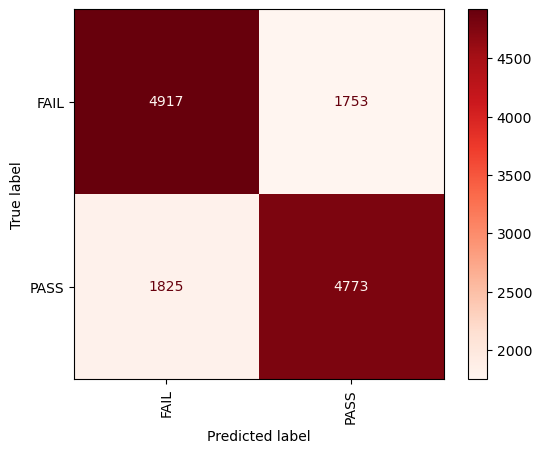

In [64]:
cm = confusion_matrix(y_test, y_pred_binary)
cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
cm_display.plot(cmap="Reds", xticks_rotation=90)

# Catboost

In [68]:
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

0:	learn: 0.6730795	total: 18.5ms	remaining: 18.4s
1:	learn: 0.6570974	total: 36.5ms	remaining: 18.2s
2:	learn: 0.6434471	total: 56ms	remaining: 18.6s
3:	learn: 0.6325197	total: 74.5ms	remaining: 18.5s
4:	learn: 0.6227838	total: 91.6ms	remaining: 18.2s
5:	learn: 0.6152268	total: 111ms	remaining: 18.4s
6:	learn: 0.6091001	total: 128ms	remaining: 18.1s
7:	learn: 0.6040541	total: 144ms	remaining: 17.9s
8:	learn: 0.6002691	total: 160ms	remaining: 17.6s
9:	learn: 0.5966397	total: 178ms	remaining: 17.6s
10:	learn: 0.5934930	total: 195ms	remaining: 17.5s
11:	learn: 0.5903688	total: 212ms	remaining: 17.5s
12:	learn: 0.5879294	total: 229ms	remaining: 17.4s
13:	learn: 0.5851681	total: 246ms	remaining: 17.4s
14:	learn: 0.5831697	total: 263ms	remaining: 17.3s
15:	learn: 0.5813061	total: 280ms	remaining: 17.2s
16:	learn: 0.5792557	total: 303ms	remaining: 17.5s
17:	learn: 0.5776547	total: 321ms	remaining: 17.5s
18:	learn: 0.5761808	total: 338ms	remaining: 17.4s
19:	learn: 0.5748910	total: 355ms	rema

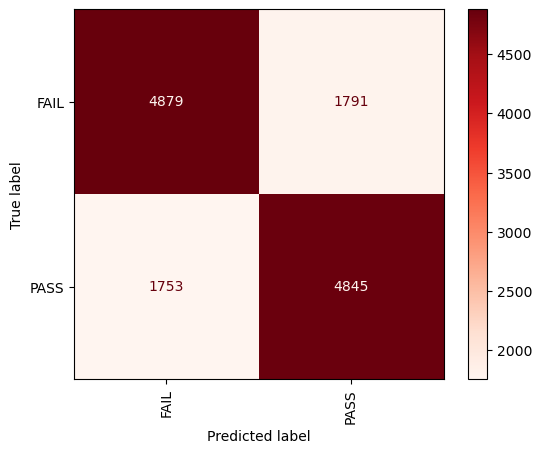

In [70]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
cm_display.plot(cmap="Reds", xticks_rotation=90)

# Keras Neural Network

## Upsample Fail Class

In [78]:
x_train, x_test, y_train, y_test = train_test_split(x_data_selected, to_categorical(y_resampled), test_size=0.2, random_state=RANDOM_STATE)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_STATE)
print(f"Train Size: {len(y_train)} --- Validation Size: {len(y_val)} --- Test Size: {len(y_test)}")

Train Size: 33965 --- Validation Size: 8492 --- Test Size: 10615


In [79]:
# define the hyperparameters to search over
param_grid = {
    'n_layers': [1, 2, 3, 4, 5, 6],
    'n_nodes': [32, 64, 128, 256, 512],
    'dropout': [0.1, 0.2, 0.3, 0.4],
    'lr': [0.0001, 0.001, 0.01, 0.1],
    'loss': ['binary_crossentropy', 'categorical_crossentropy'],
    'activation': ['sigmoid', 'softmax']
}

In [80]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

model = Sequential([
    Dense(128, activation='relu', input_shape=(len(x_train.columns),)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

Epoch 1/20
1062/1062 [==============================] - 9s 8ms/step - loss: 0.6474 - accuracy: 0.6400 - val_loss: 0.6153 - val_accuracy: 0.6830 - lr: 0.0010
Epoch 2/20
1062/1062 [==============================] - 9s 8ms/step - loss: 0.6319 - accuracy: 0.6661 - val_loss: 0.6114 - val_accuracy: 0.6892 - lr: 0.0010
Epoch 3/20
1062/1062 [==============================] - 9s 8ms/step - loss: 0.6264 - accuracy: 0.6680 - val_loss: 0.6131 - val_accuracy: 0.6813 - lr: 0.0010
Epoch 4/20
1062/1062 [==============================] - 9s 8ms/step - loss: 0.6251 - accuracy: 0.6692 - val_loss: 0.6087 - val_accuracy: 0.6902 - lr: 0.0010
Epoch 5/20
1062/1062 [==============================] - 9s 9ms/step - loss: 0.6243 - accuracy: 0.6716 - val_loss: 0.6201 - val_accuracy: 0.6766 - lr: 0.0010
Epoch 6/20
1062/1062 [==============================] - 9s 9ms/step - loss: 0.6211 - accuracy: 0.6741 - val_loss: 0.6075 - val_accuracy: 0.6930 - lr: 0.0010
Epoch 7/20
1062/1062 [==============================] - 9s

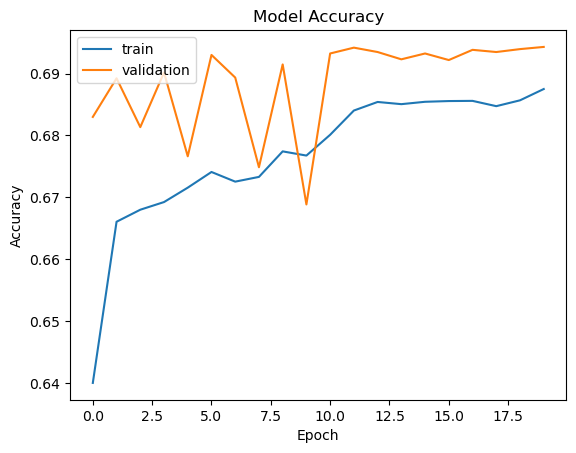

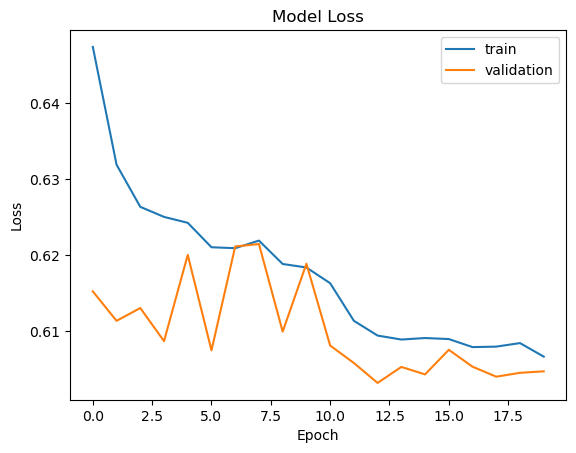

In [81]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

332/332 [==============================] - 1s 2ms/step
Accuracy of 68.32%


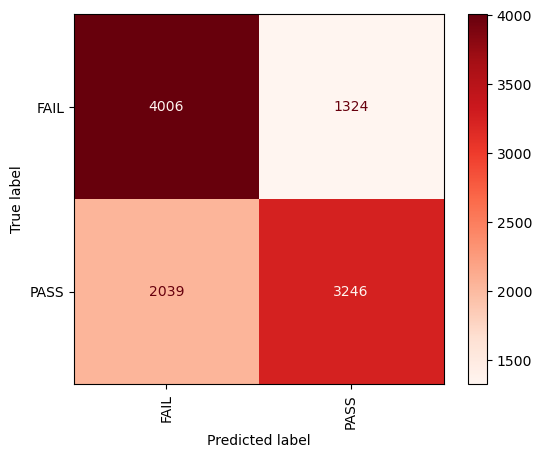

In [82]:
# create the confusion matrix for the predictions of the custom model on the test generator
pred = model.predict(x_test)
predictions = np.argmax(pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
acc = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f"Accuracy of {round(acc*100, 2)}%")
cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
cm_display.plot(cmap="Reds", xticks_rotation=90)